# Cross Validating GARCH Models

We cross validate `GARCH(p,q)` models for the best `p,q` that work for the tech stocks. 

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from arch import arch_model
from seaborn import set_style
set_style("whitegrid")

In [163]:
tech = pd.read_csv("../data/tech_data.csv", parse_dates=True, index_col="Date")

***

## Preprocessing

In [164]:
tickers = tech.columns 

## make the return columns
for tick in tickers:
    tech[tick+"_returns"] = np.log(tech[tick]) - np.log(tech[tick].shift(-1))
    tech[tick+"_vol"] = tech[tick+"_returns"].rolling(30).std()


## get the returns
returns = tech.iloc[:, 5:].dropna().copy()

In [165]:
returns

,AAPL_returns,AAPL_vol,AMZN_returns,AMZN_vol,GOOGL_returns,GOOGL_vol,MSFT_returns,MSFT_vol,NVDA_returns,NVDA_vol
Date,,,,,,,,,,
2010-02-16,0.004188,0.021233,0.010435,0.019301,0.005725,0.015724,-0.008430,0.014439,-0.009574,0.028211
2010-02-17,-0.001874,0.021233,-0.015103,0.019547,-0.009266,0.015940,-0.013204,0.014714,0.067832,0.030540
2010-02-18,0.006228,0.021082,0.004754,0.019371,0.004539,0.015444,0.006927,0.014722,0.005413,0.030479
2010-02-19,0.006217,0.021100,-0.004161,0.019260,-0.003765,0.015046,0.001391,0.014637,-0.001807,0.030356
2010-02-22,0.016907,0.021219,0.006546,0.018416,0.014343,0.014861,0.014021,0.014708,0.024376,0.030568
...,...,...,...,...,...,...,...,...,...,...
2022-12-22,0.002802,0.019077,-0.017274,0.021711,-0.016612,0.020081,-0.002265,0.018427,0.008709,0.033355
2022-12-23,0.013976,0.018672,0.026266,0.020219,0.020836,0.019671,0.007442,0.018171,0.074027,0.035130
2022-12-27,0.031166,0.019273,0.014801,0.020040,0.015801,0.019791,0.010308,0.017802,0.006038,0.035127


In [166]:
## find the index that makes the 80-20 split
splitting_index = int(len(returns.index)*0.8)

## make the train/test splits
r_train, r_test = returns[:splitting_index].copy(), returns[splitting_index:].copy()

***
## Validating GARCH

In [168]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [225]:
p_choices = [1,2,3,5,10,15,30]

kfold = TimeSeriesSplit(n_splits=3,
                        test_size=len(r_test.index))

results = pd.DataFrame(index=p_choices, columns=tickers)

for stock in tickers:

    ## make empty array for the mses
    mses = {k:[0]*5 for k in p_choices}

    ## this keeps track of which split we are on
    i = 0

    ## iterate through the splits
    for train_index, test_index in kfold.split(r_train.index):

        full_index = np.concatenate((train_index,test_index), axis=0)

        col = r_train[stock+"_returns"].copy()

        train = col[full_index]

        ## for each window we make a new model
        for p in p_choices:

            am = arch_model(train, 
                     p=p,
                     q=1,
                     vol='GARCH',
                     dist='normal',
                     rescale=False)
        

            ## last date to train the model (training set)
            last_obs = train.index[train_index[-1] + 2].date()

            ## fit the model on the data up to last_obs
            res = am.fit(update_freq=0,
                         last_obs=last_obs.strftime(format="%Y-%m-%d"),
                         disp='off')
            
            ## forecasts for all days after the last obs (holdout)
            forecasts = res.forecast(reindex=False,
                                     horizon=1
                                     )

        
            ## add the mean square error to the array
            vola = r_train[stock+"_vol"].copy()
            ## compare with observed vol 
            mses[p][i] = mean_squared_error(vola[test_index].values, np.sqrt(forecasts.variance))
        
        i += 1
    
    ## add the average mse to the dataframe
    for p in mses.keys():
        results.loc[p, stock] = np.mean(mses[p])

In [226]:
results

,AAPL,AMZN,GOOGL,MSFT,NVDA
1,0.000015,0.000026,0.000019,0.000015,0.000017
2,0.000014,0.000028,0.000018,0.00002,0.00002
3,0.000015,0.000027,0.00002,0.000016,0.000022
5,0.000013,0.000027,0.000019,0.000022,0.000027
10,0.000015,0.000026,0.000018,0.000018,0.000032
15,0.000014,0.000024,0.000018,0.000019,0.000026
30,0.00001,0.000028,0.000017,0.00001,0.000019


In [228]:
tech_p = { k:results.index[np.argmin(results[k])] for k in tickers }

tech_p

{'AAPL': 30, 'AMZN': 15, 'GOOGL': 30, 'MSFT': 30, 'NVDA': 1}

***
## Fit Validated GARCH Models

We now fit the GARCH models on the training set and test them on the `r_test`. 

{'AAPL': 0.0020969818127574984, 'AMZN': 0.005527536810736924, 'GOOGL': 0.0035622323615082598, 'MSFT': 0.002005311248418169, 'NVDA': 0.005029370286067704}


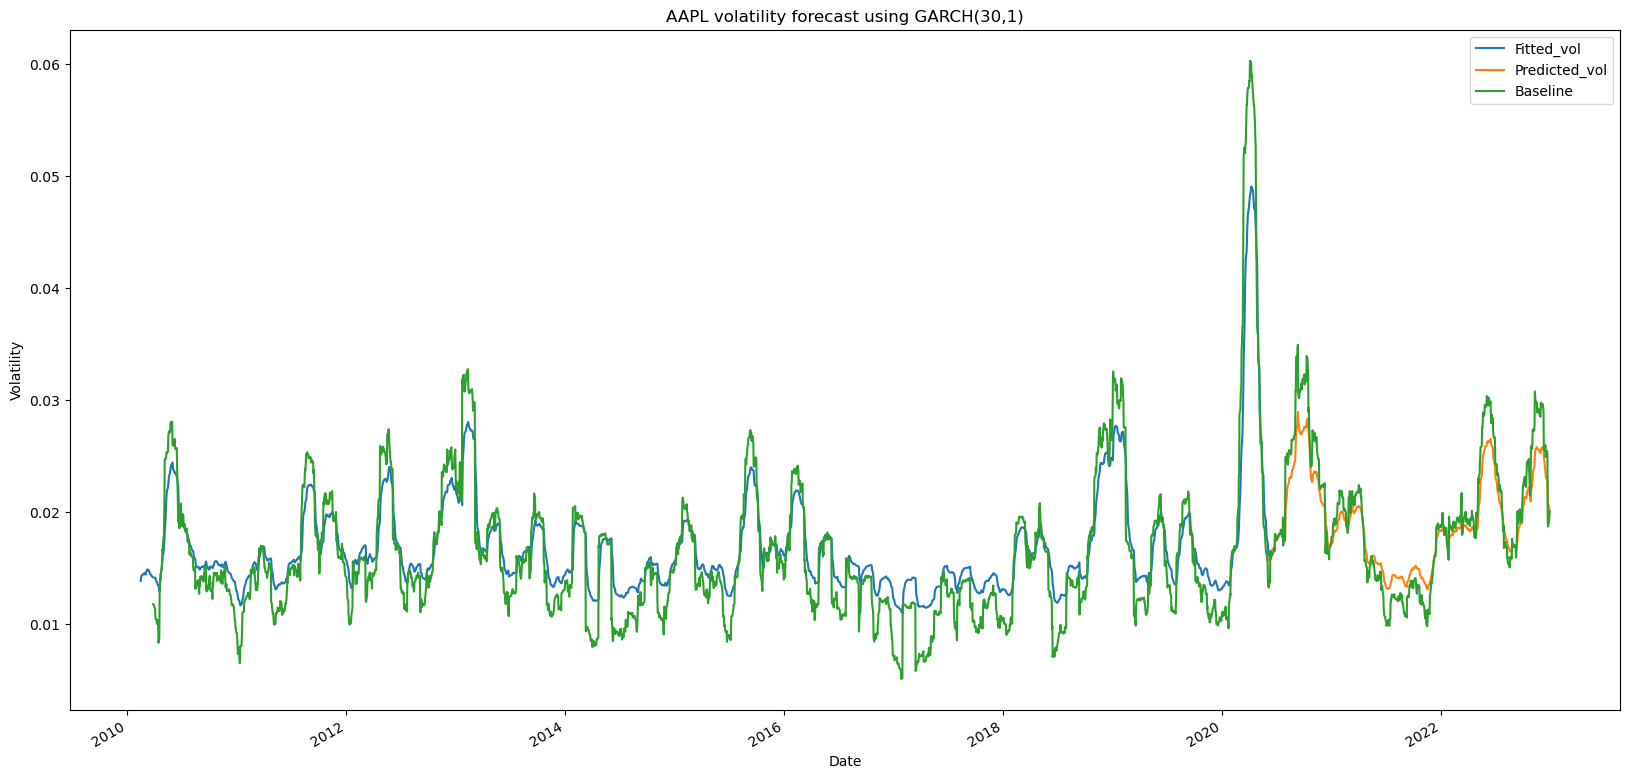

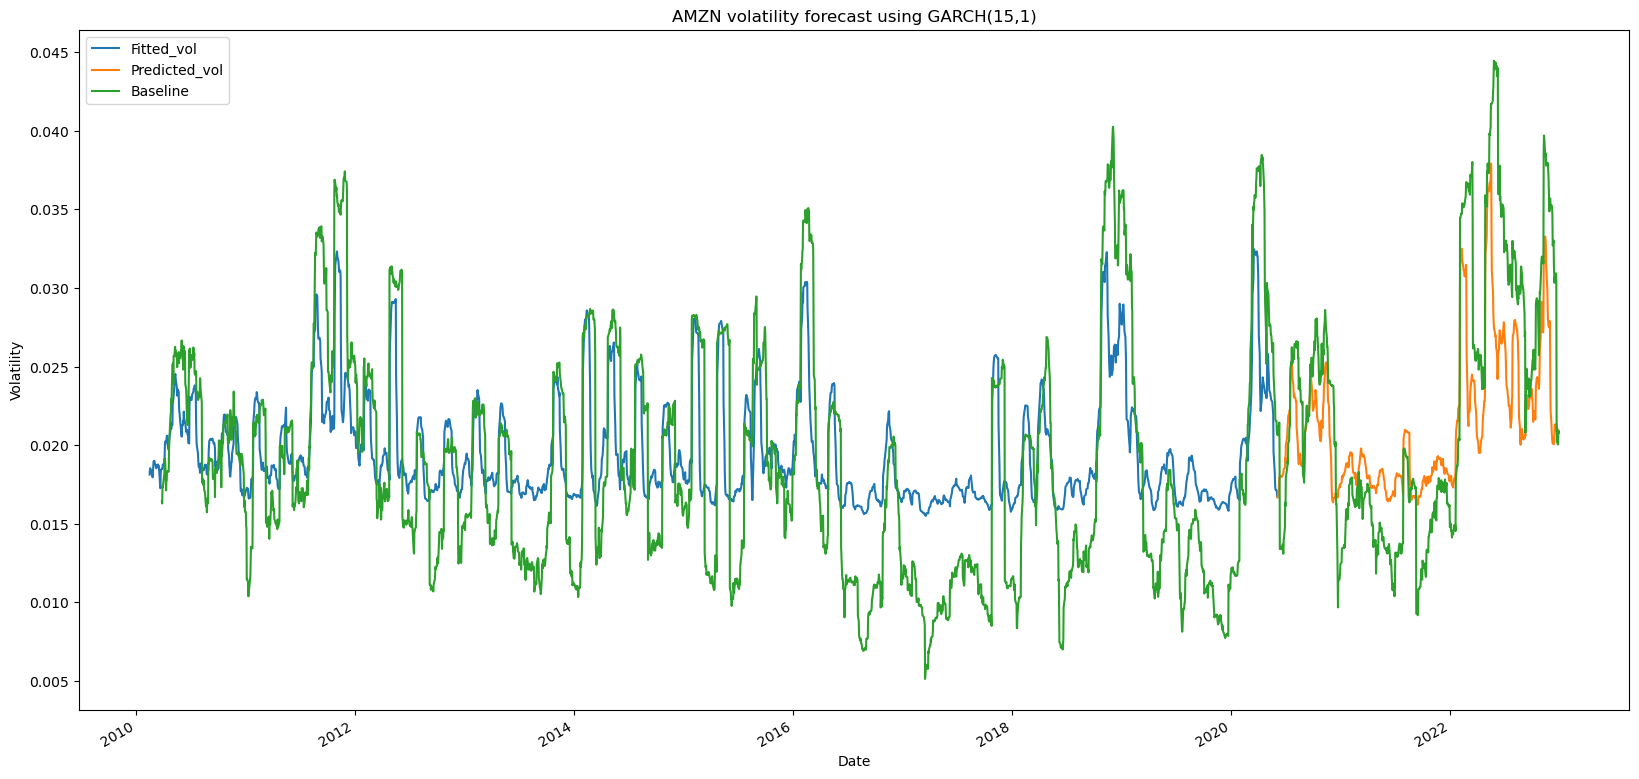

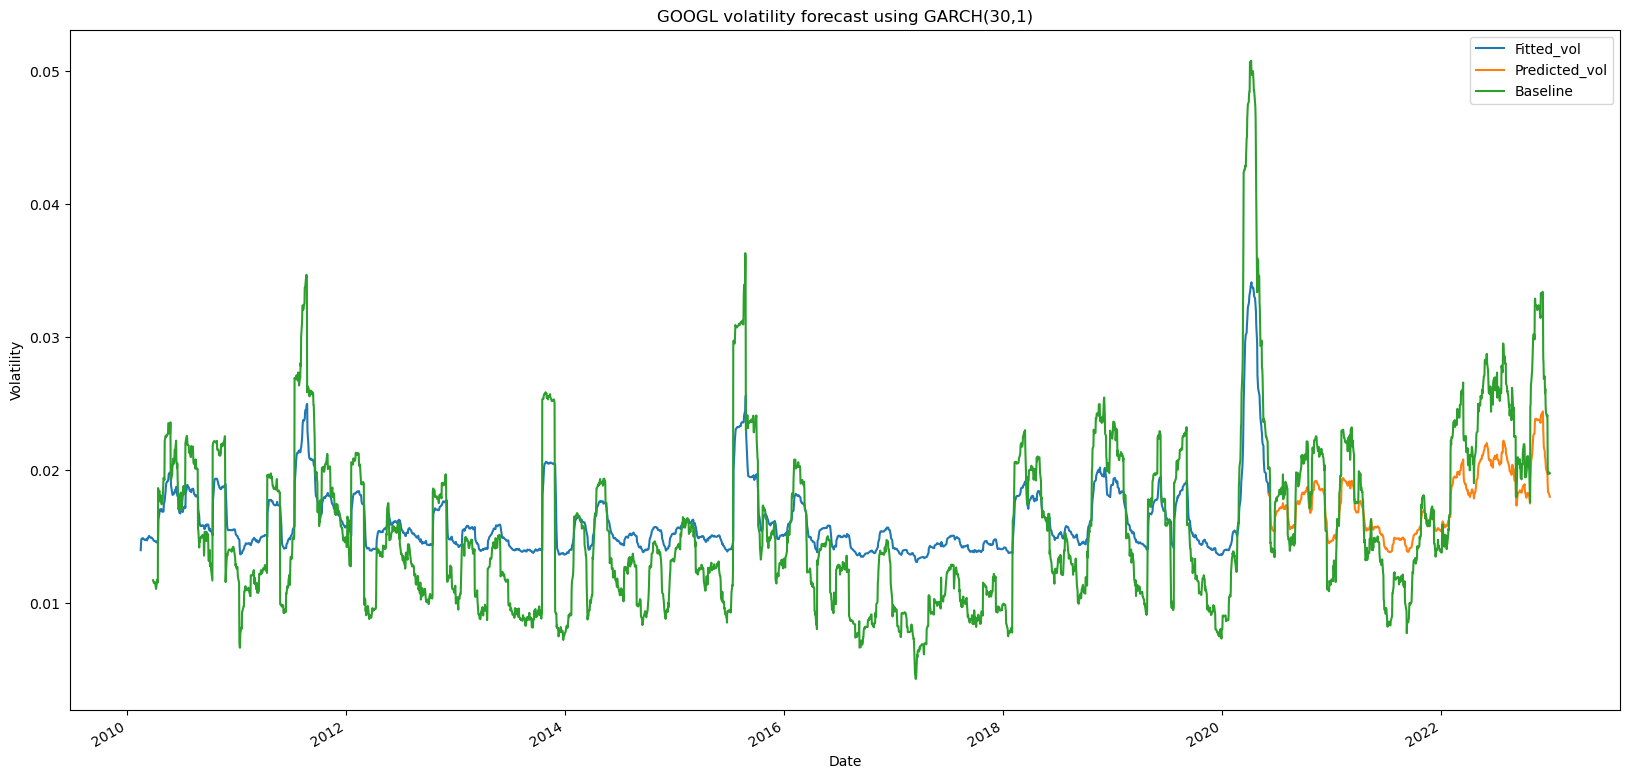

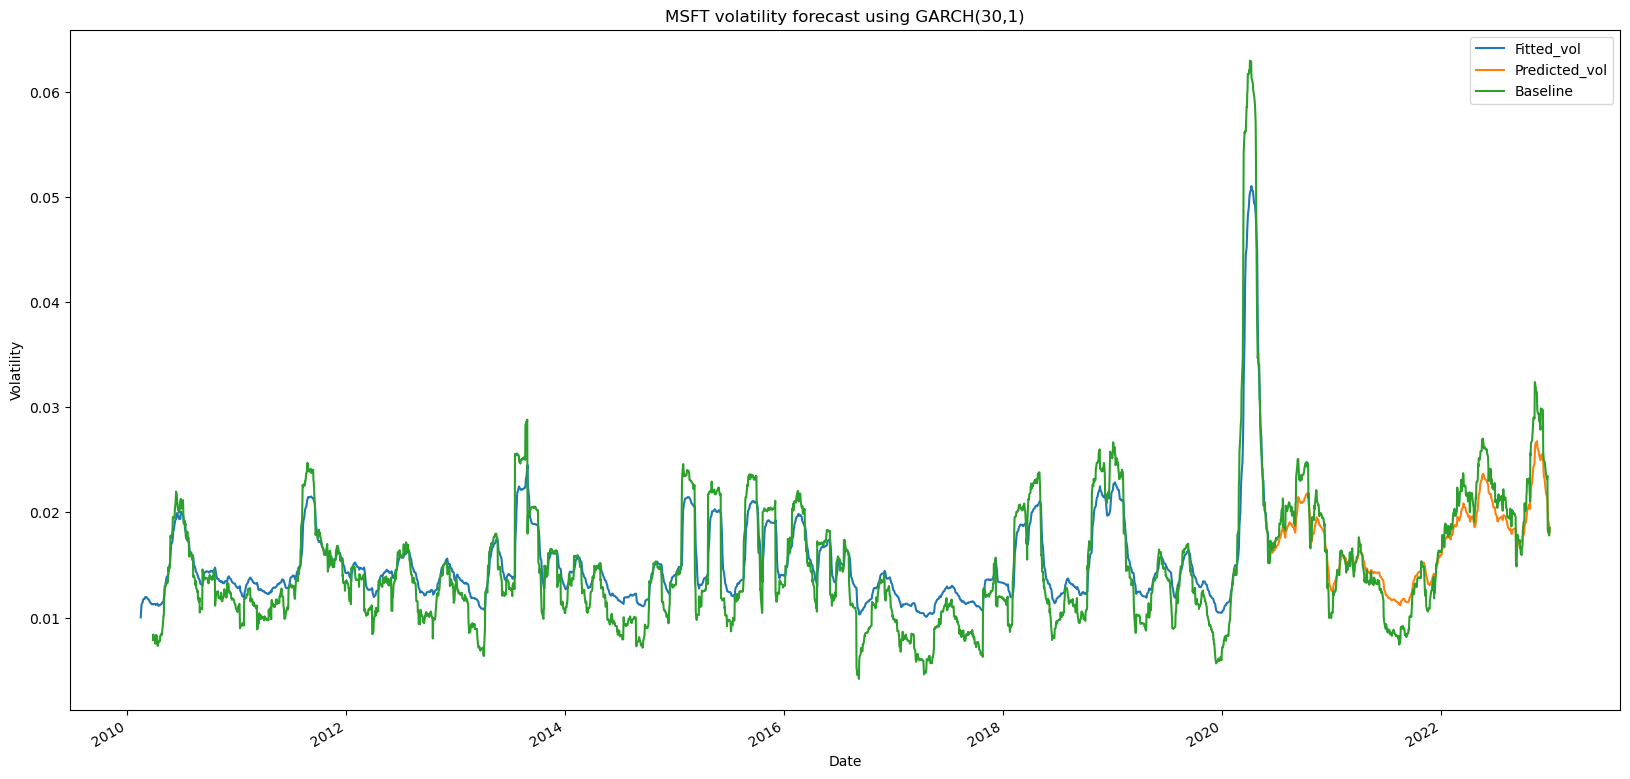

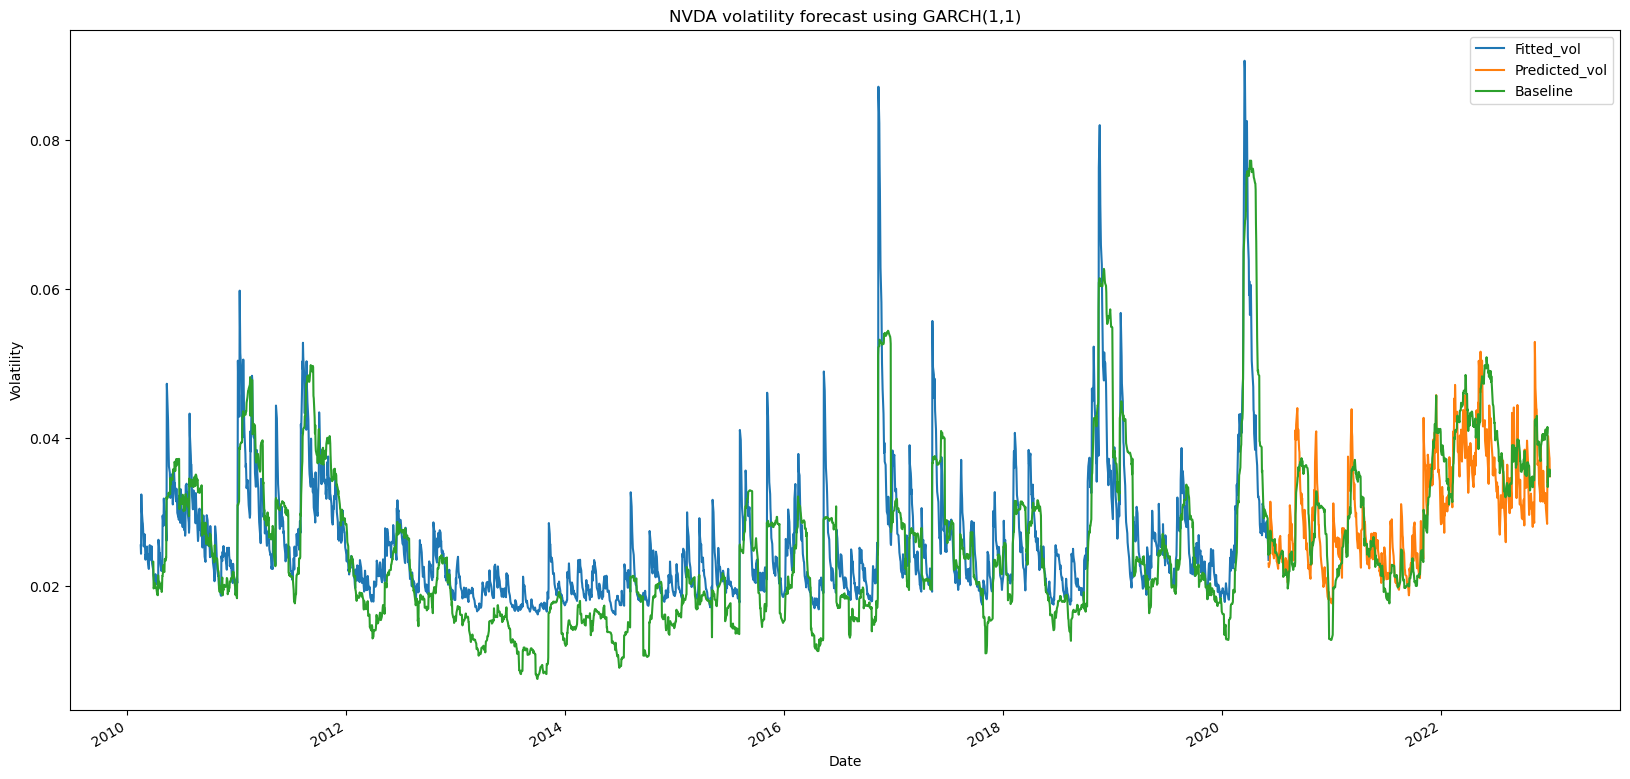

In [236]:
last_obs = r_test.index[1].date()

last_obs = last_obs.strftime("%Y-%m-%d")

mse = {}

for stock in tickers:

    ## get validated p
    p = int(tech_p[stock])

    am = arch_model(returns[stock+"_returns"],
                    p=p,
                    q=1,
                    vol='GARCH',
                    dist='normal',
                    rescale=False)

    res = am.fit(update_freq=0,
                 last_obs=last_obs,
                 disp='off')
    
    forecasts = res.forecast(reindex=False,
                             horizon=1)
    
    mse[stock] = np.sqrt(mean_squared_error(r_test[stock+"_vol"].values, np.sqrt(forecasts.variance)))

    df = returns[[stock+"_returns"]].copy()

    df["Fitted_vol"] = res.conditional_volatility

    df["Predicted_vol"] = np.sqrt(forecasts.variance)

    df["Baseline"] = df[stock+"_returns"].rolling(30).std()

    df.plot(y=["Fitted_vol", "Predicted_vol", "Baseline"],
                figsize=(20,10),
                title = f"{stock} volatility forecast using GARCH({p},1)",
                ylabel="Volatility")

print(mse)